# Softmax Tutorial

First we import the needed libraries:

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse

from sklearn.model_selection import train_test_split

In [17]:
import kagglehub
from pathlib import Path
# Download latest version
path = kagglehub.dataset_download("mujtabamatin/air-quality-and-pollution-assessment")

print("Path to dataset files:", path)

directory = Path(path)

for file in directory.iterdir():
    print(file)
df = pd.read_csv(f"{path}/updated_pollution_dataset.csv")

Path to dataset files: /home/arjunrao/.cache/kagglehub/datasets/mujtabamatin/air-quality-and-pollution-assessment/versions/2
/home/arjunrao/.cache/kagglehub/datasets/mujtabamatin/air-quality-and-pollution-assessment/versions/2/updated_pollution_dataset.csv


In [18]:
df

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good
...,...,...,...,...,...,...,...,...,...,...
4995,40.6,74.1,116.0,126.7,45.5,25.7,2.11,2.8,765,Hazardous
4996,28.1,96.9,6.9,25.0,25.3,10.8,1.54,5.7,709,Moderate
4997,25.9,78.2,14.2,22.1,34.8,7.8,1.63,9.6,379,Moderate
4998,25.3,44.4,21.4,29.0,23.7,5.7,0.89,11.6,241,Good


In [62]:
target_list = df['Air Quality'].unique().tolist()

df['Air Quality'] = df['Air Quality'].apply(lambda x: target_list.index(x))

In [63]:
x_train, x_test, y_train, y_test = train_test_split(df.drop("Air Quality", axis=1), df["Air Quality"], test_size=0.2, random_state=42)

In [77]:
def oneHotIt(Y):
    return np.eye(Y.nunique())[Y]

In [78]:
oneHotIt(y_train)

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

Here we perform the softmax transformation:
This allows us to get probabilities for each class score that sum to 100%.


<img src="https://upload.wikimedia.org/math/0/9/9/0991837b7d5a522ebc156f51dadbed0e.png">

In [79]:
def softmax(z):

    # you basically take the maximum of weight and substract it with all other weights
    z -= np.max(z)

    # You then take exponent of weights since its negative and sum it along each row 
    # You then divide each row with its transposed exponent to normalize it and transpose it back to give its original shape
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

In [80]:
def getProbsAndPreds(someX):
    probs = softmax(np.dot(someX,w))
    preds = np.argmax(probs,axis=1)
    return probs,preds

In [81]:
def getLoss(w,x,y,lam):
    m = x.shape[-2] #First we get the number of training examples
    y_mat = oneHotIt(y)
    # In this we mutlpoly every feature with its weight for 1 class. So if we have 9 features and 4 classes and total of 1000 entries, we will get 1000 x 4 matrix
    scores = np.dot(x,w)

    prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
    loss = (-3 / m) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(w*w) #We then find the loss of the probabilities
    grad = (-3 / m) * np.dot(x.T,(y_mat - prob)) + lam*w #And compute the gradient for that loss
    return loss,grad

In [ ]:
def getAccuracy(someX,someY):
    prob,prede = getProbsAndPreds(someX)
    accuracy = sum(prede == someY)/(float(len(someY)))
    return accuracy

3.7268532954484277

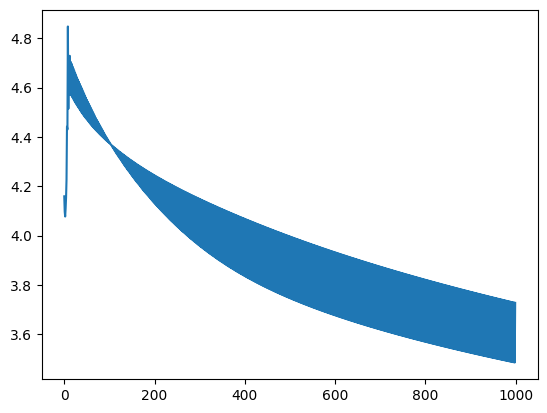

In [198]:
# We will get a 2d array of total features * total classes (NxM)
w = np.zeros([x_train.shape[1],y_train.nunique()])

lam = 1
iterations = 1000
learningRate = 1e-5
losses = []
for i in range(0,iterations):
    loss,grad = getLoss(w,x_train,y_train,lam)
    losses.append(loss)
    w = w - (learningRate * grad)

plt.plot(losses)

losses[999]

In [175]:
w = np.zeros([x_train.shape[1],y_train.nunique()])
lam = 1

m = x_train.shape[0] #First we get the number of training examples

print(m)
y_mat = oneHotIt(y_train) #Next we convert the integer class coding into a one-hot representation
scores = np.dot(x_train,w) #Then we compute raw class scores given our input and current weights

#scaling with maximum
scores -= np.max(scores)

#print(np.exp(scores).T / np.sum(np.exp(scores), axis=1))
sm = (np.exp(scores).T / np.sum(np.exp(scores),axis=1)).T

# Taking Hadamard product of ground truth and log of probablities
mult = y_mat * np.log(sm)

print(y_mat.shape,sm.shape,mult.shape)
np.sum(mult,axis=1).sum()

# We get the total loss by summing all the log of probablites for all ground truth values and the adding a regularizer term in the end to avoid overfitting
loss = (-1 / m) * np.sum(y_mat * np.log(sm)) + (lam/2)*np.sum(w*w)
grad = (-1 / m) * np.dot(x_train.T,(y_mat - sm)) + lam*w

grad.shape

x_train.T.shape
(y_mat - sm).shape

y_mat - sm

4000
(4000, 4) (4000, 4) (4000, 4)


array([[-0.25, -0.25,  0.75, -0.25],
       [-0.25,  0.75, -0.25, -0.25],
       [-0.25, -0.25, -0.25,  0.75],
       ...,
       [-0.25, -0.25, -0.25,  0.75],
       [-0.25,  0.75, -0.25, -0.25],
       [-0.25, -0.25,  0.75, -0.25]])

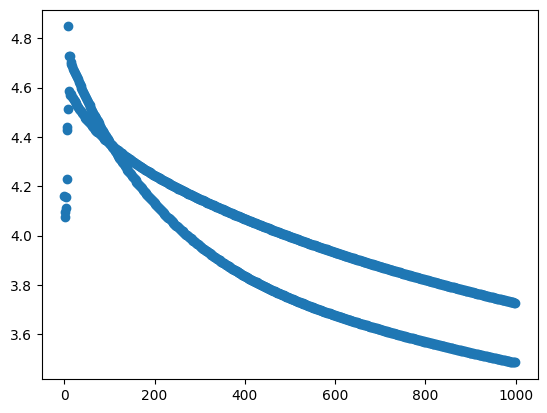

In [201]:
x = np.arange(len(losses))
plt.scatter(x,losses)

In [23]:
print 'Training Accuracy: ', getAccuracy(x,y)
print 'Test Accuracy: ', getAccuracy(testX,testY)

Training Accuracy:  0.902
Test Accuracy:  0.85
